
<div style="text-align: center;">
    <strong style="display: block; margin-bottom: 10px;">Group 07</strong> 
    <table style="margin: 0 auto; border-collapse: collapse; border: 1px solid black;">
        <tr>
            <th style="border: 1px solid white; padding: 8px;">Name</th>
            <th style="border: 1px solid white; padding: 8px;">Student ID</th>
        </tr>
        <tr>
            <td style="border: 1px solid white; padding: 8px;">Joana Rodrigues</td>
            <td style="border: 1px solid white; padding: 8px;">20240603</td>
        </tr>
        <tr>
            <td style="border: 1px solid white; padding: 8px;">Mara Simões</td>
            <td style="border: 1px solid white; padding: 8px;">20240326</td>
        </tr>
        <tr>
            <td style="border: 1px solid white; padding: 8px;">Matilde Street</td>
            <td style="border: 1px solid white; padding: 8px;">20240523</td>
        </tr>
        <tr>
            <td style="border: 1px solid white; padding: 8px;">Rafael Silva</td>
            <td style="border: 1px solid white; padding: 8px;">20240511</td>
        </tr>
    </table>
</div>

### 🔗 Table of Contents <a id='table-of-contents'></a>
1. [Imports](#imports)
---

# 1. Imports
## 1.1. Import Libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier


In [2]:
import nltk
from nltk.tokenize import word_tokenize
import string
from nltk.corpus import stopwords
import re
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from tqdm import tqdm


# # # Download NLTK resources
# nltk.download('punkt')
# nltk.download('punkt_tab')
# nltk.download('wordnet')
# nltk.download('omw-1.4')
# nltk.download('stopwords')
# nltk.download('wordnet')

## 1.2. Import Dataset

In [3]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_train = pd.DataFrame(data=df_train, columns=['text', 'label']).reset_index(drop=True)
df_test = pd.DataFrame(data=df_test, columns=['text', 'label']).reset_index(drop=True)

print(df_train.head())

                                                text  label
0  $BYND - JPMorgan reels in expectations on Beyo...      0
1  $CCL $RCL - Nomura points to bookings weakness...      0
2  $CX - Cemex cut at Credit Suisse, J.P. Morgan ...      0
3  $ESS: BTIG Research cuts to Neutral https://t....      0
4  $FNKO - Funko slides after Piper Jaffray PT cu...      0


# 2. Exploratory Data Analysis

In [4]:
print('Initial dataset contains ', df_train.shape[0], 'rows and ', df_train.shape[1], 'columns')

Initial dataset contains  9543 rows and  2 columns


The dataset contains 3 unique labels to predict.
label
2    6178
1    1923
0    1442
Name: count, dtype: int64


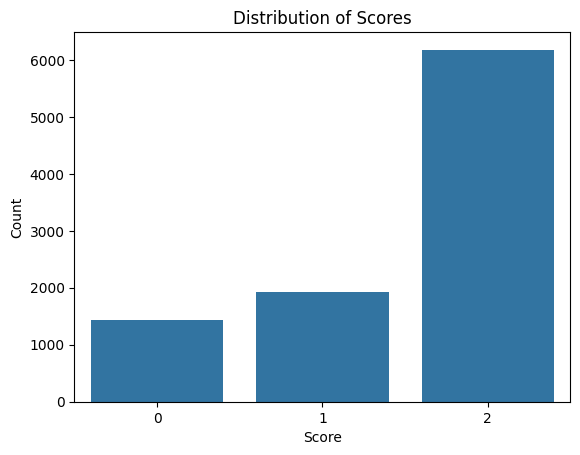

In [5]:
print('The dataset contains', df_train['label'].nunique(), 'unique labels to predict.')
print(df_train['label'].value_counts())
# Visualize distribution of satisfaction
sns.countplot(data=df_train, x='label')
plt.title("Distribution of Scores")
plt.xlabel("Score")
plt.ylabel("Count")
plt.show()

To see the words that appear the most in our dataset

In [6]:
all_words = ' '.join(df_train['text']).split()
freq = pd.Series(all_words).value_counts()
freq.sort_values(ascending=False)[0:10]

to     2332
the    1820
of     1464
-      1390
in     1361
on     1136
for    1032
a       970
and     898
The     663
Name: count, dtype: int64

There appears the same word 'the' for example twice because it is in lower and upper case. Therefore we will have to deal with that in the preprocessing steps.

# 3. Exploratory Data Analysis
## 3.1. Missing values

In [7]:
if df_train.isnull().sum().sum() > 0:
    print('There are missing values in the dataset')
else: 
    print('There are no missing values in the dataset')  


There are no missing values in the dataset


## 3.2. Feature engineering

In [8]:
df_train['text_length'] = df_train['text'].apply(len)
df_train['word_count']  = df_train['text'].apply(lambda x: len(str(x).split(" ")))


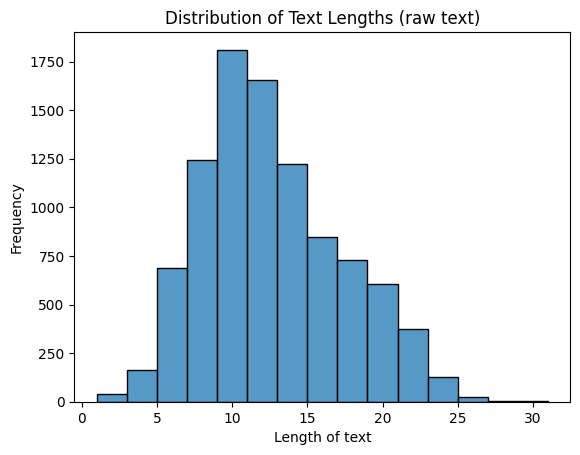

In [9]:
#Plot distribution of text length
sns.histplot(df_train['word_count'], bins=15)
plt.title("Distribution of Text Lengths (raw text)")
plt.xlabel("Length of text")
plt.ylabel("Frequency")
plt.show()

## 3.3. Outliers

In [10]:
to_remove = df_train['text_length'].quantile(0.005)

print('We will eliminate the texts with less than', to_remove, 'length')  #0.5 percentile

#to see where the labels of the errors
removed_labels = df_train[df_train['text_length'] < 18]['label'].value_counts()
print(removed_labels)

#to see what is being eliminated:
removed = df_train.loc[df_train['text_length'] < 18, ['text', 'label', 'text_length']]
print(removed)

df_train = df_train[df_train['text_length'] >= 18]
df_train = df_train[df_train['text_length'] >= 18].reset_index(drop=True)

We will eliminate the texts with less than 18.0 length
label
2    42
1     5
Name: count, dtype: int64
                   text  label  text_length
1858   SASA聚酯选用英威达PTA技术      2           16
3090          Brent +4%      1            9
3943                 :)      2            2
3948            @TicToc      2            7
3980      100% Correct!      2           13
4358  Cya Jason Garrett      2           17
4360               Damn      2            4
4440                 F5      2            2
4914         Next week.      2           10
5006      Racing on Ice      2           13
5484    Wholesale Trade      2           15
5512         Woke Sachs      2           10
5654         $penn coin      2           10
6511     Housing Starts      2           14
6849     Nasdaq up 0.2%      1           14
6990  Averages end flat      2           17
7935      $WW heavy....      1           13
8055          Long $WMT      1            9
8153    $APOP on scans.      2           15
8167       $CEI W

## 3.4. All text in english
Mudança para a mesma lingua (não serviu de nada)

In [11]:
# from langdetect import detect


# def detect_language(text):
#     try:
#         return detect(text)  
#     except:
#         return 'unknown' 

# df_train['language'] = df_train['text'].apply(detect_language)

# language_distribution = df_train['language'].value_counts()

# print(language_distribution)

# print( df_train[df_train['language'] == 'unknown'], 'tweets with unknown language.')



In [12]:
# initial_rows = len(df_train)

# language_counts = df_train['language'].value_counts()

# languages_to_keep = language_counts[language_counts > 1].index

# df_train = df_train[df_train['language'].isin(languages_to_keep)]

# final_rows = len(df_train)

# removed_rows = initial_rows - final_rows
# print(f"{removed_rows} linhas foram removidas.")


In [13]:
# from googletrans import Translator

# translator = Translator()

# def translate_to_english(text, detected_language):
#     try:
#         if detected_language != 'en':
#             translated = translator.translate(text, src=detected_language, dest='en')
#             return translated.text
#         else:
#             return text
#     except Exception as e:
#         print(f"Error translating text: {e}")
#         return text

# df_train['translated_text'] = df_train.apply(
#     lambda row: translate_to_english(row['text'], row['language']),
#     axis=1)


# df_french = df_train[df_train['language'] == 'pt']
# df_french[['text', 'clean_text']].head(20)



## 3.5. Cleaning text
Application of a formula that will:
1. Remove the stopwords
2. Stemeatize & Lematize
3. Put everything in lowercase
3. Remove weird characters

In [14]:
stop = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')
lemma = WordNetLemmatizer()

def clean(text_list, lemmatize=True, stem=False):
    cleaned = []

    for text in tqdm(text_list):
        text = text.lower()

        text = re.sub("[^a-zA-Z]", " ", text)
        text = re.sub("br", "", text)
        text = re.sub(r"http\S+", "", text)
        text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)

        text = " ".join([word for word in text.split() if word not in stop])

        if lemmatize:
            text = " ".join(lemma.lemmatize(word) for word in text.split())

        if stem:
            text = " ".join(stemmer.stem(word) for word in text.split())

        cleaned.append(text)

    return cleaned

df_train['clean_text'] = clean(df_train['text'], lemmatize=True, stem=True)
df_test['clean_text'] = clean(df_test['text'], lemmatize=True, stem=True)

df_train[['text', 'clean_text']].head()


100%|██████████| 2388/2388 [00:00<00:00, 8507.77it/s]


,text,clean_text
0,$BYND - JPMorgan reels in expectations on Beyo...,bynd jpmorgan reel expect beyond meat co bd xb...
1,$CCL $RCL - Nomura points to bookings weakness...,ccl rcl nomura point book weak carniv royal ca...
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",cx cemex cut credit suiss j p morgan weak buil...
3,$ESS: BTIG Research cuts to Neutral https://t....,es btig research cut neutral co mcyftsxc n
4,$FNKO - Funko slides after Piper Jaffray PT cu...,fnko funko slide piper jaffray pt cut co z ijm...


## 3.6 Removing unsual words

In [15]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df_train['clean_text'])
words = vectorizer.get_feature_names_out()
word_counts = X.toarray().sum(axis=0)
words_once = [word for word, count in zip(words, word_counts) if count == 1]

print("Words that appear only once:", words_once)


Words that appear only once: ['aaa', 'aac', 'aaci', 'aacitcwia', 'aaham', 'aakmr', 'aam', 'aaon', 'aapemwrmvn', 'aapiyhqm', 'aasl', 'aav', 'aawthd', 'aaww', 'aaza', 'abalon', 'abbott', 'abcdo', 'abdefgjwlz', 'abe', 'abeb', 'aben', 'abeo', 'aberdeen', 'abevi', 'abhjrhyhfd', 'abiy', 'abjk', 'abk', 'abmzokmqwl', 'abn', 'abo', 'abohhqlbea', 'abolish', 'abort', 'absol', 'absorb', 'absurd', 'abu', 'abukarsh', 'abv', 'abxui', 'aca', 'academ', 'acbah', 'acbvso', 'acceleron', 'acceleronpharma', 'accendowav', 'accesswi', 'accion', 'accommod', 'accor', 'accordi', 'accret', 'accur', 'accuraci', 'acd', 'acea', 'acelerada', 'acelrx', 'ach', 'acj', 'acmr', 'acn', 'acnotpflvt', 'acorncapitalinvestmentfund', 'acpkbt', 'acpnf', 'acpohatzzq', 'acqu', 'acquisizioni', 'acquitt', 'acrx', 'actinogen', 'actinogenmed', 'actividad', 'actuari', 'acu', 'acui', 'acx', 'acyqwv', 'adam', 'adani', 'adapt', 'adcoxgj', 'adecco', 'adenatfriedman', 'adesco', 'adesto', 'adfdkheaw', 'adghnjkpx', 'adia', 'adida', 'adjuv', '

In [16]:
words_once_set = set(words_once)

def remove_rare_words(text):
    return ' '.join([word for word in text.split() if word not in words_once_set])

df_train['clean_text'] = df_train['clean_text'].apply(remove_rare_words)


# 4. Model

In [17]:
X_train = df_train['clean_text']
y_train = df_train['label'] 

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

## 4.1. Vectorization

In [18]:
def bow_or_tfidf(texts = df_train['clean_text'], method='bow'):
    if method == 'bow':
        vectorizer = CountVectorizer()
        X = vectorizer.fit_transform(texts)
        return X, vectorizer

    elif method == 'tfidf':
        vectorizer = TfidfVectorizer()
        X = vectorizer.fit_transform(texts)
        return X, vectorizer

    else:
        raise ValueError("Choose a valid method: 'bow', 'tfidf'.")

#X_train, vectorizer = bow_or_tfidf(df_train['clean_text'], method='bow')
# X_train, vectorizer = bow_or_tfidf(df_train['clean_text'], method='tfidf')



## 4.2. Function for evaluation of the model

In [19]:
def evaluate_model_predictions(y_pred_train, y_pred_val, y_train = y_train, y_val = y_val, show_confusion_matrix = True, show_classification_report = True):
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_f1 = f1_score(y_train, y_pred_train, average='macro')
    
    val_accuracy = accuracy_score(y_val, y_pred_val)
    val_f1 = f1_score(y_val, y_pred_val, average='macro')

    val_precision = precision_score(y_val, y_pred_val, average='macro')
    val_recall = recall_score(y_val, y_pred_val, average='macro')

    print(f"Accuracy of train: {train_accuracy:.4f}")
    print(f"F1 Macro (Train): {train_f1:.4f}")
    print(f"Accuracy of val: {val_accuracy:.4f}")
    print(f"\033[1mF1 Macro (Val)\033[0m: {val_f1:.4f}")
    print(f"Precision (Val): {val_precision:.4f}")
    print(f"Recall (Val): {val_recall:.4f}")
    
    
    if show_confusion_matrix==True:
        print('\nConfusion Matrix for Validation Data:')    
        print(confusion_matrix(y_val, y_pred_val))

    if show_classification_report==True:
        print('\nClassification Report for Validation Data:')
        print(classification_report(y_val, y_pred_val))

    return train_accuracy, train_f1, val_accuracy, val_f1

## 4.4. Models

In [20]:
X_train_bow, vectorizer = bow_or_tfidf(X_train, method='bow')

X_val_bow = vectorizer.transform(X_val)
#X_test_bow = vectorizer.transform(df_test['clean_text']) 


lr = LogisticRegression()
lr.fit(X_train_bow, y_train)
y_pred_train = lr.predict(X_train_bow)
y_pred_val = lr.predict(X_val_bow)


# Results:
lr_bow_train_accuracy, lr_bow_train_f1_macro, lr_bow_val_accuracy, lr_bow_val_f1_macro = evaluate_model_predictions(y_pred_train=y_pred_train, y_pred_val =y_pred_val)


Accuracy of train: 0.9475
F1 Macro (Train): 0.9299
Accuracy of val: 0.7963
F1 Macro (Val): 0.7110
Precision (Val): 0.7517
Recall (Val): 0.6839

Confusion Matrix for Validation Data:
[[ 158   29  102]
 [  30  226  133]
 [  39   54 1129]]

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.70      0.55      0.61       289
           1       0.73      0.58      0.65       389
           2       0.83      0.92      0.87      1222

    accuracy                           0.80      1900
   macro avg       0.75      0.68      0.71      1900
weighted avg       0.79      0.80      0.79      1900



In [21]:
knn = KNeighborsClassifier(n_neighbors=5) 
knn.fit(X_train_bow, y_train)

y_pred_train = knn.predict(X_train_bow)
y_pred_val = knn.predict(X_val_bow)

knn_bow_train_accuracy, knn_bow_train_f1_macro, knn_bow_val_accuracy, knn_bow_val_f1_macro = evaluate_model_predictions(y_pred_train=y_pred_train, y_pred_val=y_pred_val)


Accuracy of train: 0.8103
F1 Macro (Train): 0.7160
Accuracy of val: 0.6826
F1 Macro (Val): 0.5169
Precision (Val): 0.5780
Recall (Val): 0.4976

Confusion Matrix for Validation Data:
[[  85   24  180]
 [  49  118  222]
 [  65   63 1094]]

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.43      0.29      0.35       289
           1       0.58      0.30      0.40       389
           2       0.73      0.90      0.81      1222

    accuracy                           0.68      1900
   macro avg       0.58      0.50      0.52      1900
weighted avg       0.65      0.68      0.65      1900



In [30]:
mlp = MLPClassifier(solver='adam', hidden_layer_sizes=(2,2), activation='logistic', random_state=1)
mlp.fit(X_train_bow, y_train)

y_pred_train = mlp.predict(X_train_bow)
y_pred_val = mlp.predict(X_val_bow)

mlp_bow_train_accuracy, mlp_bow_train_f1_macro, mlp_bow_val_accuracy, mlp_bow_val_f1_macro = evaluate_model_predictions(y_pred_train=y_pred_train, y_pred_val=y_pred_val)


Accuracy of train: 0.9392
F1 Macro (Train): 0.8920
Accuracy of val: 0.7053
F1 Macro (Val): 0.5322
Precision (Val): 0.5446
Recall (Val): 0.5401

Confusion Matrix for Validation Data:
[[  45  127  117]
 [  45  231  113]
 [  55  103 1064]]

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.31      0.16      0.21       289
           1       0.50      0.59      0.54       389
           2       0.82      0.87      0.85      1222

    accuracy                           0.71      1900
   macro avg       0.54      0.54      0.53      1900
weighted avg       0.68      0.71      0.69      1900



C:\Users\joana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [22]:
X_train_tfidf, vectorizer = bow_or_tfidf(X_train, method='tfidf')
X_val_tfidf = vectorizer.transform(X_val)
#X_test_tfidf = vectorizer.transform(df_test['clean_text']) 


lr = LogisticRegression()
lr.fit(X_train_tfidf, y_train)
y_pred_train = lr.predict(X_train_tfidf)
y_pred_val = lr.predict(X_val_tfidf)

# Results:
lr_idf_train_accuracy, lr_idf_train_f1_macro, lr_idf_val_accuracy, lr_idf_val_f1_macro = evaluate_model_predictions(y_pred_train=y_pred_train, y_pred_val =y_pred_val)


Accuracy of train: 0.8504
F1 Macro (Train): 0.7807
Accuracy of val: 0.7805
F1 Macro (Val): 0.6615
Precision (Val): 0.7900
Recall (Val): 0.6133

Confusion Matrix for Validation Data:
[[ 113   27  149]
 [  15  187  187]
 [   9   30 1183]]

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.82      0.39      0.53       289
           1       0.77      0.48      0.59       389
           2       0.78      0.97      0.86      1222

    accuracy                           0.78      1900
   macro avg       0.79      0.61      0.66      1900
weighted avg       0.78      0.78      0.76      1900



Models more complicated

In [23]:
import gensim
from gensim.models import Word2Vec
from sklearn.preprocessing import normalize

def word_embeddings(texts, method='word2vec', window_size=2, min_count=1, vector_size=100):

    # Tokenize
    tokenized = [text.split() for text in texts]

    if method == 'term_term':
        vectorizer = CountVectorizer()
        X = vectorizer.fit_transform(texts)
        term_term_matrix = (X.T * X)
        np.fill_diagonal(term_term_matrix.toarray(), 0)
        words = vectorizer.get_feature_names_out()
        df = pd.DataFrame(term_term_matrix.toarray(), index=words, columns=words)
        return df

    elif method == 'pmi':
        # Build term-term co-occurrence matrix
        vectorizer = CountVectorizer()
        X = vectorizer.fit_transform([' '.join(doc) for doc in tokenized])
        vocab = vectorizer.get_feature_names_out()
        cooc_matrix = (X.T @ X).toarray()
        np.fill_diagonal(cooc_matrix, 0)

        total = cooc_matrix.sum()
        row_sum = cooc_matrix.sum(axis=1, keepdims=True)
        col_sum = cooc_matrix.sum(axis=0, keepdims=True)

        expected = (row_sum @ col_sum) / total
        with np.errstate(divide='ignore'):
            pmi = np.log2(cooc_matrix / expected)
        pmi[np.isinf(pmi)] = 0
        pmi[pmi < 0] = 0  # Only positive PMI (PPMI)

        df = pd.DataFrame(pmi, index=vocab, columns=vocab)
        return df

    elif method == 'word2vec':
        model = Word2Vec(sentences=tokenized, vector_size=vector_size, window=window_size, min_count=min_count, sg=1)
        word_vectors = model.wv
        # Convert to DataFrame for easier use
        df = pd.DataFrame({word: word_vectors[word] for word in word_vectors.index_to_key}).T
        return df

    else:
        raise ValueError("Choose one of: 'term_term', 'pmi', 'word2vec'")



In [24]:
# Train embeddings
w2v_df = word_embeddings(df_train['clean_text'], method='word2vec')
def get_doc_embedding(doc, embeddings_df, dim=100):
    tokens = doc.split()
    vectors = [embeddings_df.loc[word] for word in tokens if word in embeddings_df.index]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(dim)

# Build feature matrix
X_train = np.vstack([get_doc_embedding(doc, w2v_df) for doc in X_train])
X_val = np.vstack([get_doc_embedding(doc, w2v_df) for doc in X_val])

X_test = np.vstack([get_doc_embedding(doc, w2v_df) for doc in df_test['clean_text']])


clf = LogisticRegression()
clf.fit(X_train, y_train)

y_pred_train = clf.predict(X_train)
y_pred_val = clf.predict(X_val)


In [25]:
lr_emb_train_accuracy, lr_emb_train_f1_macro, lr_emb_val_accuracy, lr_idf_val_f1_macro = evaluate_model_predictions(y_pred_train=y_pred_train, y_pred_val =y_pred_val)


Accuracy of train: 0.6617
F1 Macro (Train): 0.3520
Accuracy of val: 0.6616
F1 Macro (Val): 0.3472
Precision (Val): 0.3898
Recall (Val): 0.3797

Confusion Matrix for Validation Data:
[[   0   36  253]
 [   0   63  326]
 [   0   28 1194]]

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       289
           1       0.50      0.16      0.24       389
           2       0.67      0.98      0.80      1222

    accuracy                           0.66      1900
   macro avg       0.39      0.38      0.35      1900
weighted avg       0.53      0.66      0.56      1900



C:\Users\joana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\joana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\joana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati

## Results

In [26]:
# Define model results dictionary

model_results = {
    'Simple Models': [
        'LR_BOW', 'LR_IDF', 
    ],
    'Train Accuracy': [
        lr_bow_train_accuracy, lr_idf_train_accuracy
    ],
    'Val Accuracy': [
        lr_bow_val_accuracy, lr_idf_val_accuracy,
    ],
    'Train F1 Score': [
        lr_bow_train_f1_macro, lr_idf_train_f1_macro, 
    ],
    'Val F1 Score': [
        lr_bow_val_f1_macro, lr_idf_val_f1_macro
    ]
}

# Create DataFrame with the results
results_models = pd.DataFrame(model_results)

# Set 'Simple Models' column as the index
results_models.set_index('Simple Models', inplace=True)

results_models

,Train Accuracy,Val Accuracy,Train F1 Score,Val F1 Score
Simple Models,,,,
LR_BOW,0.947472,0.796316,0.929909,0.711044
LR_IDF,0.850448,0.780526,0.780679,0.347172


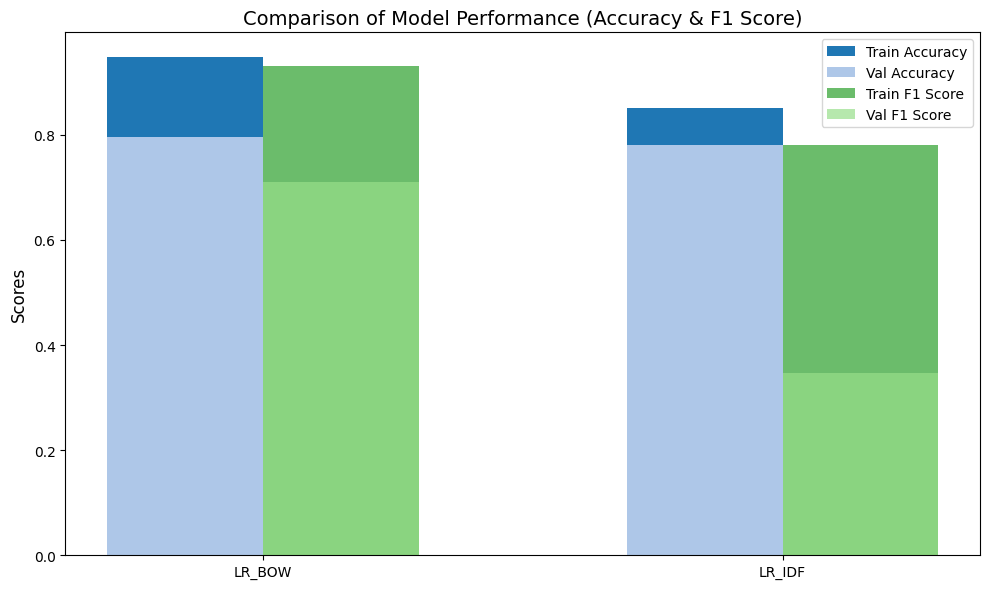

In [ ]:
model_names = results_models.index

train_accuracy = results_models['Train Accuracy']
val_accuracy = results_models['Val Accuracy']
train_f1 = results_models['Train F1 Score']
val_f1 = results_models['Val F1 Score']

bar_width = 0.3
index = np.arange(len(model_names))

fig, ax = plt.subplots(figsize=(10, 6))

bar_tra = ax.bar(index - bar_width / 2, train_accuracy, bar_width, label='Train Accuracy', color='#1F77B4' )
bar_ta = ax.bar(index - bar_width / 2, val_accuracy, bar_width, label='Val Accuracy', color='#AEC7E8')

bar_trf = ax.bar(index + bar_width / 2, train_f1, bar_width, label='Train F1 Score', alpha=0.7, color= '#2CA02C' )
bar_tf = ax.bar(index + bar_width / 2, val_f1, bar_width, label='Val F1 Score', alpha=0.7, color='#98DF8A')

ax.set_ylabel('Scores', fontsize=12)
ax.set_title('Comparison of Model Performance (Accuracy & F1 Score)', fontsize=14)

ax.set_xticks(index)
ax.set_xticklabels(model_names)

ax.legend()

plt.tight_layout()
plt.show()


The best model is... so we will do the val set with those predictions

In [28]:
#y_pred_val =lr.predict(X_val_tfidf)


# ids = pd.DataFrame(df_val.index) 
# predict_df = pd.DataFrame(y_pred_val, columns=['label'])

# final = pd.concat([ids, predict_df], axis=1)

# final.reset_index(drop=True, inplace=True)
# final.to_csv('df_val_prediction.csv', index=False)